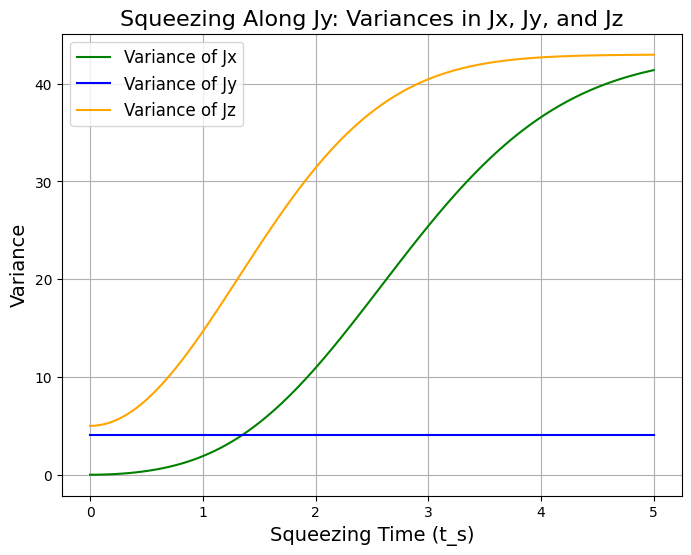

In [1]:
import numpy as np
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt

def jmat(j, axis):
    """
    Generate the spin-j operator for the given axis ('x', 'y', or 'z').
    
    Parameters:
        j (float): Spin quantum number.
        axis (str): 'x', 'y', or 'z'.
    
    Returns:
        ndarray: The spin operator matrix.
    """
    m_vals = np.arange(j, -j-1, -1)
    dim = int(2 * j + 1)
    J = np.zeros((dim, dim), dtype=complex)
    
    if axis == 'z':
        np.fill_diagonal(J, m_vals)
    elif axis == 'x':
        for m in range(dim - 1):
            J[m, m + 1] = J[m + 1, m] = 0.5 * np.sqrt((j - m_vals[m]) * (j + m_vals[m + 1]))
    elif axis == 'y':
        for m in range(dim - 1):
            J[m, m + 1] = -0.5j * np.sqrt((j - m_vals[m]) * (j + m_vals[m + 1]))
            J[m + 1, m] = 0.5j * np.sqrt((j - m_vals[m]) * (j + m_vals[m + 1]))
    
    return J

def coherent_spin_state(j, theta, phi):
    """
    Generate a coherent spin state aligned along the direction (theta, phi).
    
    Parameters:
        j (float): Spin quantum number.
        theta (float): Polar angle (angle with z-axis).
        phi (float): Azimuthal angle (angle with x-axis).
    
    Returns:
        ndarray: Coherent spin state vector.
    """
    dim = int(2 * j + 1)
    state = np.zeros((dim, 1), dtype=complex)
    
    for m in range(dim):
        m_val = j - m
        binomial_factor = np.sqrt(math.factorial(2 * j) / (math.factorial(j + m_val) * math.factorial(j - m_val)))
        state[m] = binomial_factor * (np.cos(theta / 2) ** (j + m_val)) * (np.sin(theta / 2) ** (j - m_val))
    
    return state * np.exp(1j * phi * (j - np.arange(0, dim).reshape(-1, 1)))

def apply_squeezing_operator(j, chi, t_s):
    """
    Apply the squeezing operator exp(-i * chi * t_s * Jy^2).
    
    Parameters:
        j (float): Spin quantum number.
        chi (float): Squeezing strength.
        t_s (float): Squeezing time.
    
    Returns:
        ndarray: Squeezing operator matrix for squeezing along Jz.
    """
    Jy = jmat(j, 'y')
    return expm(-1j * chi * t_s * np.dot(Jy, Jy))  # Squeezing along Jy

def variance(operator, state):
    """
    Compute the variance of an operator in the given state.
    
    Parameters:
        operator (ndarray): The spin operator matrix.
        state (ndarray): The state vector.
    
    Returns:
        float: The variance of the operator.
    """
    expectation_value = np.vdot(state, np.dot(operator, state))
    expectation_value_squared = np.abs(expectation_value) ** 2
    operator_squared = np.dot(operator, operator)
    expectation_value_operator_squared = np.vdot(state, np.dot(operator_squared, state))
    return np.abs(expectation_value_operator_squared - expectation_value_squared)

def plot_variances_during_squeezing(j, chi, t_values):
    """
    Plot the variances of Jx, Jy, and Jz over time during the squeezing process.
    
    Parameters:
        j (float): Total spin quantum number (N/2).
        chi (float): Squeezing strength.
        t_values (array): Array of squeezing times to simulate.
    
    Returns:
        None: Plots the variance changes in Jx, Jy, and Jz over time.
    """
    Jx = jmat(j, 'x')
    Jy = jmat(j, 'y')
    Jz = jmat(j, 'z')

    # Generate coherent spin state along z-axis (aligned with z-axis for squeezing)
    coherent_state = coherent_spin_state(j, np.pi / 2, 0)

    # Lists to store variance values over time
    var_Jx_values = []
    var_Jy_values = []
    var_Jz_values = []

    # Loop through squeezing times
    for t_s in t_values:
        # Apply squeezing along Jz
        squeezing_operator = apply_squeezing_operator(j, chi, t_s)
        squeezed_state = np.dot(squeezing_operator, coherent_state)

        # Measure variances
        var_Jx = variance(Jx, squeezed_state)
        var_Jy = variance(Jy, squeezed_state)
        var_Jz = variance(Jz, squeezed_state)

        var_Jx_values.append(var_Jx)
        var_Jy_values.append(var_Jy)
        var_Jz_values.append(var_Jz)

    # Plot the variances
    plt.figure(figsize=(8, 6))
    plt.plot(t_values, var_Jx_values, label='Variance of Jx', color='green')
    plt.plot(t_values, var_Jy_values, label='Variance of Jy', color='blue')
    plt.plot(t_values, var_Jz_values, label='Variance of Jz', color='orange')
    plt.xlabel("Squeezing Time (t_s)", fontsize=14)
    plt.ylabel("Variance", fontsize=14)
    plt.title("Squeezing Along Jy: Variances in Jx, Jy, and Jz", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Example usage:
j = 10  # Total spin quantum number (e.g., N = 20 particles)
chi = 0.1  # Squeezing strength
t_values = np.linspace(0, 5.0, 100)  # Time values for squeezing evolution

# Plot variance changes during squeezing
plot_variances_during_squeezing(j, chi, t_values)


In [18]:
import numpy as np
import qutip as qt

# Define the squeezing Hamiltonian using chi and Jz
def apply_squeezing_via_oat(j, chi, t_s):
    Jz = qt.jmat(j, 'z')  # Collective spin operator along the z-axis
    H_squeeze = chi * Jz ** 2  # One-axis twisting Hamiltonian
    return (-1j * H_squeeze * t_s).expm()  # Time-evolution operator

def test_squeezed_state(j, chi, t_s):
    """
    Test the coherent state and its squeezing by checking the expectation values 
    and variances before and after squeezing.
    
    Parameters:
        j (float): Total spin quantum number (N/2).
        chi (float): Squeezing strength.
        t_s (float): Squeezing time.
    
    Returns:
        None: Prints the test results for the coherent and squeezed states.
    """
    # Generate coherent state aligned along the x-axis
    coherent_state = qt.spin_coherent(j, np.pi / 2, np.pi/2)

    # Define collective spin operators
    Jx = qt.jmat(j, 'x')
    Jy = qt.jmat(j, 'y')
    Jz = qt.jmat(j, 'z')

    # Variances before squeezing
    var_Jx_before = qt.variance(Jx, coherent_state)
    var_Jy_before = qt.variance(Jy, coherent_state)
    var_Jz_before = qt.variance(Jz, coherent_state)
    
    print("Before Squeezing:")
    print(f"  Var(Jx): {var_Jx_before}")
    print(f"  Var(Jy): {var_Jy_before}")
    print(f"  Var(Jz): {var_Jz_before}")

    # Apply squeezing via the OAT Hamiltonian
    squeezing_operator = apply_squeezing_via_oat(j, chi, t_s)
    squeezed_state = squeezing_operator * coherent_state

    # Variances after squeezing
    var_Jx_after = qt.variance(Jx, squeezed_state)
    var_Jy_after = qt.variance(Jy, squeezed_state)
    var_Jz_after = qt.variance(Jz, squeezed_state)
    
    print("\nAfter Squeezing:")
    print(f"  Var(Jx): {var_Jx_after}")
    print(f"  Var(Jy): {var_Jy_after}")
    print(f"  Var(Jz): {var_Jz_after}")

# Example usage:
j = 10  # Total spin quantum number (e.g., N = 20 particles)
chi = 0.1  # Squeezing strength
t_s = 1.0  # Squeezing time

# Test the coherent state and its squeezing
test_squeezed_state(j, chi, t_s)


Before Squeezing:
  Var(Jx): 5.000000000000004
  Var(Jy): -7.105427357601002e-14
  Var(Jz): 5.000000000000004

After Squeezing:
  Var(Jx): 19.440670988724328
  Var(Jy): 2.889668532914925
  Var(Jz): 5.000000000000004
